In [8]:
import networkx as nx
from SocialAnonymizer import SocialAnonymizer
from utils import plot_component, check_isomorphic_classes
from MDFScoder import MDFSCoder
import matplotlib.pyplot as plt

## Analysis

### 1. Temporal efficiency

In the paper, the minimum DFS code is adopted in order to recognize and match isomoprhic components when analyzing the neighborhood of a pair of nodes. However, the complexity of computing the Minimum DFS Code is factorial (O(N!)) in the worst case. The worst case is a clique (i.e., complete graph). At node 1, we have N−1 choices for the next step.
At node 2, we have N−2 choices and so on. This results in (N−1)! different DFS traces to compare. The search can be pruned by comparing the current trace with the currently best one found: if it results larger from the comparison, the search is pruned in that direction. For this reason, the code for producing the exact minimum DFS code of a graph is provided, but not used in `SocialAnonymizer`.

Heuristics limiting the search space for determining the minimum DFS code can be used. However, by definition, heuristics may not spot the actual minimum code and adjust to a non-minimum code for graphs. As a consequence, they can produce false negatives (i.e., isomoprhic graphs not recognized as such) or/and false positives (i.e., non-isomoprhic graphs recognized as such). False positives are a treath to privacy. Why? Because in the algorithm perfect component matches are not further manipulated to reach isomoprhism since they are considered already isomoprhic. Hence, the occurence of false positives may leave in the final anonymized graph some nodes whose neighborhood is unique. Therefore, neighborhood attacks can be performed on those nodes. On the other hand, false negatives are not a problem, because, if the components are matched correctly by `most_similar_component` and the mapping satysfing isomoprhism is found, then `make_components_isomorphic` will apply no changes to the components, mantaining isomoprhism. However, if the false negatives are not paired correctly by `most_similar_component` or a wrong mapping is used, the algorithm leads to overanonymization (i.e., adding edges or generalizing label when not stricly necessary, causing an unnecessary information loss). Hence, heuristics admitting only false negatives can be adopted to speed up the process at the cost of utility. 

NetworkX library provides the `is_isomorphic` method which implements the VF2 algorithm described in the paper 'An Improved Algorithm for Matching Large Graphs' (2001) by L. P. Cordella et al.. The algorithm is exact (i.e., no false positives nor false negatives can occur) and factorial in the worst case as well. However, on average, it is considerably faster than the custom implementation of the minimum DFS code provided because of a more refined pruning mechanism. This is the reason why it was adopted in the project replacing the MDFS for the isomoprhism check. 

In [ ]:
# compare is_isomorphic and MDFcode
import random 
import time 
import numpy as np
import matplotlib.pyplot as plt

def custom_is_isomoprhic(G: nx.Graph, H: nx.Graph)-> bool:
    coder = MDFSCoder()
    code1 = coder.get_code(G)
    code2 = coder.get_code(H)

    if code1 == code2: 
        return True
    else:
        return False

def random_iso_pair(n, p, seed):
    G = nx.erdos_renyi_graph(n, p, seed=seed)
    nodes = list(G.nodes())
    perm = dict(zip(nodes, random.sample(nodes, len(nodes))))
    H = nx.relabel_nodes(G, perm)
    return G, H

def random_non_iso_pair(n, p, seed):
    return nx.erdos_renyi_graph(n, p, seed=seed), nx.erdos_renyi_graph(n, p, seed=seed)

def positive_benchmark(ns, p, seed, trials=50):
    results_MDFS = []
    results_vf2 = []

    for n in ns:
        times_MDFS = []
        times_vf2 = []

        for _ in range(trials):
            G, H = random_iso_pair(n, p, seed)

            start_time = time.time()
            result = custom_is_isomoprhic(G, H)
            end_time = time.time()
            times_MDFS.append(end_time-start_time)

            start_time = time.time()
            result = nx.is_isomorphic(G, H) # inside it istanciate a Graph Matcher
            end_time = time.time()
            times_vf2.append(end_time-start_time)

        results_MDFS.append(np.mean(times_MDFS))
        results_vf2.append(np.mean(times_vf2))

    return results_MDFS, results_vf2

def negative_benchmark(ns, p, seed, trials=50):
    results_MDFS = []
    results_vf2 = []

    for n in ns:
        times_MDFS = []
        times_vf2 = []

        for _ in range(trials):
            G, H = random_non_iso_pair(n, p, seed)

            start_time = time.time()
            result = custom_is_isomoprhic(G, H)
            end_time = time.time()
            times_MDFS.append(end_time-start_time)

            start_time = time.time()
            result = nx.is_isomorphic(G, H) # inside it istanciate a Graph Matcher
            end_time = time.time()
            times_vf2.append(end_time-start_time)

        results_MDFS.append(np.mean(times_MDFS))
        results_vf2.append(np.mean(times_vf2))

    return results_MDFS, results_vf2

# Run the experiment
ns = [10, 15, 20, 25, 30]#, 35, 40]
p = 0.2

pos_MDFS_times, pos_vf2_times = positive_benchmark(ns, p, seed=42, trials=5)
neg_MDFS_times, neg_vf2_times = negative_benchmark(ns, p, seed=42, trials=5)

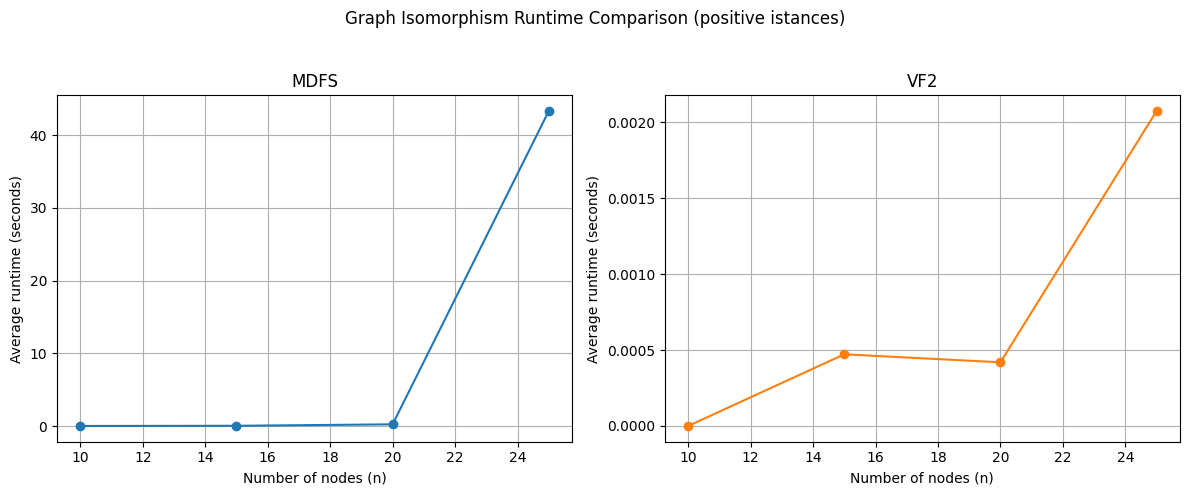

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # note: sharey removed

# Plot MDFS
axes[0].plot(ns, pos_MDFS_times, marker='o', color='tab:blue')
axes[0].set_title('MDFS')
axes[0].set_xlabel('Number of nodes (n)')
axes[0].set_ylabel('Average runtime (seconds)')
axes[0].grid(True, which='both')

# Plot VF2
axes[1].plot(ns, pos_vf2_times, marker='o', color='tab:orange')
axes[1].set_title('VF2')
axes[1].set_xlabel('Number of nodes (n)')
axes[1].set_ylabel('Average runtime (seconds)')
axes[1].grid(True, which='both')

# Adjust layout
plt.suptitle('Graph Isomorphism Runtime Comparison (positive istances)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # note: sharey removed

# Plot MDFS
axes[0].plot(ns, neg_MDFS_times, marker='o', color='tab:blue')
axes[0].set_title('MDFS')
axes[0].set_xlabel('Number of nodes (n)')
axes[0].set_ylabel('Average runtime (seconds)')
axes[0].grid(True, which='both') 

# Plot VF2
axes[1].plot(ns, neg_vf2_times, marker='o', color='tab:orange')
axes[1].set_title('VF2')
axes[1].set_xlabel('Number of nodes (n)')
axes[1].set_ylabel('Average runtime (seconds)')
axes[1].grid(True, which='both')

# Adjust layout
plt.suptitle('Graph Isomorphism Runtime Comparison (negative istances)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The paper does not provide a formal time complexity for the anonymization algorithm. However, since the only two methods through which we manipulate the graph are edge addition and label generalization, the algorithm is proved to terminate for a finite social network of at least k vertices, as stated in theorem 4. Indeed, in the worst case, the network is anonymized to a clique.    
Despite the termination theorem, the time complexity of the `anonymize_graph` function is quite high, primarily due to the subgraph isomorphism checks and the restart mechanisms triggered by topology changes in neighborhoods.     
We can list many costly operation performed by the algorithm:
- Vertex List Management (Sorting)
- Candidate Selection
- Group stabilization, whose loop is bounded by the maximum number of edges that can be added to the group's neighborhood.
- `anonymize_pair` which is the bottleneck because of Component Extraction, isomorphism checks, Greedy component Matching (once picked the largest, we simulate anonymiation to pick the component with smallest anonymization cost) and restart loop if components merge.       

The dominant factor corresponds to the isomorphism checks. The algorithm scales very poorly with the node degree. If you run this on a graph with high-degree hubs (e.g., influencers in a social network), it will be extremely slow. It works best on sparse graphs where d is small. It scales quadratically with the number of nodes due to the re-sorting and candidate scanning steps.

In [ ]:
import time

# goal: evaluate the amount of time needed to execute a function

k_values = [2, 3, 4]
graph_sizes = [10, 15, 20, 25, 30]
num_of_repetition = 5
seed = 123

results = {k: [] for k in k_values}

for size in graph_sizes:
    
    for k in k_values:

        experiment_averages = []
        durations = []
        G = nx.gnp_random_graph(n=size, p=0.1, seed=seed)

        for _ in range(num_of_repetition):  # remove randomness of a single execution

            time_start = time.time()
            G_anon, eq_classes = social_anonymizer.anonymize_graph(G_random, k=4, alpha=0, beta=1, gamma=1)
            time_end = time.time()

            durations.append(time_end - time_start)

        duration_average = sum(durations) / len(durations)
        experiment_averages.append(duration_average)

        # Average over all experiments
        overall_average = sum(experiment_averages) / len(experiment_averages)

        results[k].append((size, overall_average))

plt.figure()

for k, data in results.items():
    sizes = [x[0] for x in data]
    times = [x[1] for x in data]

    plt.plot(sizes, times, marker='o', label=f"k = {k}")

plt.xlabel("Graph Size (Number of Nodes)")
plt.ylabel("Average Runtime (seconds)")
plt.title("Scalability of Graph Anonymization Algorithm")
plt.legend()
plt.grid(True)
plt.show()

### 2. Graph Metrics

When it comes to graph, a lot of information is held also by **graph metrics**.    
Since we are dealing with social networks, node popularity (i.e., degree centrality) is particularly relevant as centrality metric. We'll be evaluating it along betweeness centrality, closeness, pagerank and reachability. We'll measure reachability as the number of connected components in the graph. As in Barabasi-Albert model, by construction, the graph is completely connected, such metric will be relevant only when considering random graphs as baseline or real social networks.     
The paper exploits two ways to anonymize the neighborhoods of vertices: generalizing vertex labels and adding edges. The 5 metrics above do not consider node labels, hence they will change after anonymization only because of edges modification. The information loss in graph metrics is only caused by edge addition.     
Since edges are ony added (and never removed), we can expect that, in general, graph metrics will change as follows:

1. the distribution of degree centrality starts as a power law distribution and it will tend to flatten. When anonymized into a clique, the distribution will be characterized by a single value, |V|-1, representing the degree of all the nodes. The closer is k to the number of nodes, the more evident the flattening effect. When k = |V|, every node will have the same degree value, which can be |V|-1 if anonymized into a clique or less if an isomoprhic pattern with less edges is found. 
2. the distribution of the betweeness in nodes from a hyperbolic shape in social networks (many nodes with low betweeness, few nodes with high betweeness) will tend to flatten and converge to a unique value as well. If the graph under analysis is anonymized into a clique, every node will have the same betweeness centrality value.  As for degree centrality, the higher is k the faster the distribution flattens. When k = |V|, every node will have the same betweeness centrality value. If the anonymized graph is connected, the betweeness centrality of all the nodes will be finite values. 
3. closeness will tend to increase. Adding edges reduces path length and makes nodes closer. 
4. enforcing k-neighborhood isomorphism by only adding edges tends to slightly redistribute PageRank from high-degree hubs to low-degree nodes, leading to a minor flattening of the PageRank distribution. Hubs remain dominant.
5. reachability tends to improve and the number of components to decrease.     

If K = |V| we find regular patterns. 

#### 2.1 Degree centrality

#### 2.2 Betweeness centrality

#### 2.3 Closeness centrality

#### 2.4 PageRank

#### 2.5 Reachability

### 3. Anonymization Quality Measure

The anonymization cost defined in the paper depends on three parameters: alpha, beta and gamma. Alpha guides the influence of the information loss caused by labels generalization. Beta defines the relevance given to the loss caused by edge addition. Gamma is related to the addition of new nodes in the neighborhood instead. Changing these three parameters will change the anonymization cost. 

In [ ]:

#cost = social_anonymizer.anonymization_cost()


---------------------
Seed Vertex:  2
Processing group  [2, 5]
Processing pair 2-5
---------------------
Seed Vertex:  0
Processing group  [0, 8]
Processing pair 0-8
---------------------
Seed Vertex:  3
Processing group  [3, 9]
Processing pair 3-9
---------------------
Seed Vertex:  5
Processing group  [5, 2]
Processing pair 5-2
---------------------
Seed Vertex:  8
Processing group  [8, 0]
Processing pair 8-0
---------------------
Seed Vertex:  10
Processing group  [10, 14]
Processing pair 10-14
---------------------
Seed Vertex:  5
Processing group  [5, 2]
Processing pair 5-2
---------------------
Seed Vertex:  19
Processing group  [19, 16]
Processing pair 19-16
---------------------
Seed Vertex:  13
Processing group  [13, 12]
Processing pair 13-12
---------------------
Seed Vertex:  4
Processing group  [4, 17]
Processing pair 4-17
---------------------
Seed Vertex:  2
Processing group  [2, 5]
Processing pair 2-5
---------------------
Seed Vertex:  17
Processing group  [17, 11]
Proc

### 4. Query Ability

### 5. Privacy vs Utility

The trade-off between privacy and utility is quite evident in this scenario. 
- 1 utility, 0 privacy: original graph
- 1 privacy, 0 utility: clique with '*' as label for every node    

As previosuly discussed, we adopt two modifications for anonymization, of which one is perturbative (i.e., the addition of edges, which alters the truthness of data) and one is non-perturbative (i.e., the generalization of ndoe labels, which does not alter the truthness of data).    
Notice that not all graphs with k=|V| will result in cliques with '*' as node labels. If we consider sparse graph (random graphs with small p), this is likely to happen. However, in social networks, it is indeed frequent to get cliques, since replicating the hubs easily result in highly dense anon graphs. 